In [1]:
import numpy as np
from model_vanilla_rot2d import DCGAN
from utils import pp, visualize, to_json, show_all_variables, expand_path, timestamp

import tensorflow as tf
import cv2
import time
import io
import IPython.display
import PIL.Image
import matplotlib.pyplot as plt
import os

In [2]:
def imshow(a, im_size=256, format='png', jpeg_fallback=True, filename=None):
  if a.dtype != np.uint8:
      a = a*255
  a = np.asarray(a, dtype=np.uint8)
  a = cv2.resize(a, (a.shape[1], a.shape[0]))

  str_file = io.BytesIO()
  PIL.Image.fromarray(a).save(str_file, format)
  im_data = str_file.getvalue()
  try:
    disp = IPython.display.display(IPython.display.Image(im_data))
    if filename:
        size = (a.shape[1]//2, a.shape[0]//2)
        im = PIL.Image.fromarray(a)
        im.thumbnail(size,PIL.Image.ANTIALIAS)
        im.save('{}.{}'.format(filename, format))
        
  except IOError:
    if jpeg_fallback and format != 'jpeg':
      print ('Warning: image was too large to display in format "{}"; '
             'trying jpeg instead.').format(format)
      return imshow(a, format='jpeg')
    else:
      raise
  return disp

In [3]:
def imgrid(imarray, cols=5, pad=1):
  if imarray.dtype != np.uint8:
    raise ValueError('imgrid input imarray must be uint8')
  pad = int(pad)
  assert pad >= 0
  cols = int(cols)
  assert cols >= 1
  N, H, W, C = imarray.shape
  rows = int(np.ceil(N / float(cols)))
  batch_pad = rows * cols - N
  assert batch_pad >= 0
  post_pad = [batch_pad, pad, pad, 0]
  pad_arg = [[0, p] for p in post_pad]
  imarray = np.pad(imarray, pad_arg, 'constant', constant_values=255)
  H += pad
  W += pad
  grid = (imarray
          .reshape(rows, cols, H, W, C)
          .transpose(0, 2, 1, 3, 4)
          .reshape(rows*H, cols*H, C))
  if pad:
    grid = grid[:-pad, :-pad]
  return grid

In [4]:
initializer = tf.global_variables_initializer()
config = tf.ConfigProto(log_device_placement=False)
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
#sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
sess.run(initializer)

In [5]:
def initialize_uninitialized(sess):
    global_vars          = tf.global_variables()
    is_not_initialized   = sess.run([tf.is_variable_initialized(var) for var in global_vars])
    not_initialized_vars = [v for (v, f) in zip(global_vars, is_not_initialized) if not f]

    print([str(i.name) for i in not_initialized_vars]) # only for testing
    if len(not_initialized_vars):
        sess.run(tf.variables_initializer(not_initialized_vars))
        return not_initialized_vars

In [6]:
file_name = 'rot2d_aug_argminW_alphamax20_lr0.0002'
out_dir_path = '/data/scratch/jahanian/mnist_dcgantf_bkup/out_old'
checkpoint_dir = os.path.join(out_dir_path,file_name,'checkpoint' )
sample_dir = os.path.join(out_dir_path,file_name,'sample' )
num_samples = 10 # 1 sample per digit

flags = tf.app.flags
flags.DEFINE_integer("epoch", 25, "Epoch to train [25]")
flags.DEFINE_float("learning_rate", 0.0002, "Learning rate of for adam [0.0002]")
flags.DEFINE_float("beta1", 0.5, "Momentum term of adam [0.5]")
flags.DEFINE_float("train_size", np.inf, "The size of train images [np.inf]")
flags.DEFINE_integer("batch_size", num_samples, "The size of batch images [64]")
flags.DEFINE_integer("input_height", 28, "The size of image to use (will be center cropped). [108]")
flags.DEFINE_integer("input_width", 28, "The size of image to use (will be center cropped). If None, same value as input_height [None]")
flags.DEFINE_integer("output_height", 28, "The size of the output images to produce [64]")
flags.DEFINE_integer("output_width", 28, "The size of the output images to produce. If None, same value as output_height [None]")
flags.DEFINE_string("dataset", "mnist", "The name of dataset [celebA, mnist, lsun]")
flags.DEFINE_boolean("aug", False, "True for enabling transformation augmentation")
flags.DEFINE_string("input_fname_pattern", "*.jpg", "Glob pattern of filename of input images [*]")
flags.DEFINE_string("data_dir", "./data", "path to datasets [e.g. $HOME/data]")
flags.DEFINE_string("out_dir", "./out", "Root directory for outputs [e.g. $HOME/out]")
flags.DEFINE_string("out_name", "", "Folder (under out_root_dir) for all outputs. Generated automatically if left blank []")
# flags.DEFINE_string("checkpoint_dir", "checkpoint", "Folder (under out_root_dir/out_name) to save checkpoints [checkpoint]")
flags.DEFINE_string("checkpoint_dir", checkpoint_dir, "Folder (under out_root_dir/out_name) to save checkpoints [checkpoint]")
# flags.DEFINE_string("sample_dir", "samples", "Folder (under out_root_dir/out_name) to save samples [samples]")
flags.DEFINE_string("sample_dir", sample_dir, "Folder (under out_root_dir/out_name) to save samples [samples]")
flags.DEFINE_boolean("train", False, "True for training, False for testing [False]")
flags.DEFINE_boolean("crop", False, "True for training, False for testing [False]")
flags.DEFINE_boolean("visualize", False, "True for visualizing, False for nothing [False]")
flags.DEFINE_boolean("export", False, "True for exporting with new batch size")
flags.DEFINE_boolean("freeze", False, "True for exporting with new batch size")
flags.DEFINE_integer("max_to_keep", 1, "maximum number of checkpoints to keep")
flags.DEFINE_integer("sample_freq", 200, "sample every this many iterations")
flags.DEFINE_integer("ckpt_freq", 200, "save checkpoint every this many iterations")
flags.DEFINE_integer("z_dim", 100, "dimensions of z")
flags.DEFINE_integer("y_dim", 10, "choose dimensions of y to be 10")
flags.DEFINE_string("z_dist", "uniform_signed", "'normal01' or 'uniform_unsigned' or uniform_signed")
flags.DEFINE_boolean("G_img_sum", False, "Save generator image summaries in log")
#flags.DEFINE_integer("generate_test_images", 100, "Number of images to generate during test. [100]")
# only for jupyter:
flags.DEFINE_string('f', '', 'kernel')

FLAGS = flags.FLAGS

In [7]:
num_samples = FLAGS.batch_size # this is a bug, DCGAN.y placeholder is fixed to 64 but what if we want 1 sample?
dcgan = DCGAN(
    sess,
    input_width=FLAGS.input_width,
    input_height=FLAGS.input_height,
    output_width=FLAGS.output_width,
    output_height=FLAGS.output_height,
    batch_size=FLAGS.batch_size,
    sample_num=num_samples,
    y_dim=FLAGS.y_dim,
    z_dim=FLAGS.z_dim,
    dataset_name=FLAGS.dataset,
    aug=FLAGS.aug,    
    input_fname_pattern=FLAGS.input_fname_pattern,
    crop=FLAGS.crop,
    checkpoint_dir=FLAGS.checkpoint_dir,
    sample_dir=FLAGS.sample_dir,
    data_dir=FLAGS.data_dir,
    out_dir=FLAGS.out_dir,
    max_to_keep=FLAGS.max_to_keep)

load_success, load_counter = dcgan.load(FLAGS.checkpoint_dir)
if not load_success:
    raise Exception("Checkpoint not found in " + FLAGS.checkpoint_dir)

rot2d aug is disabled
loading mnist without augmenting ...
model_vanilla_rot2d ...
 [*] Reading checkpoints... /data/scratch/jahanian/mnist_dcgantf_bkup/out_old/rot2d_aug_argminW_alphamax20_lr0.0002/checkpoint
INFO:tensorflow:Restoring parameters from /data/scratch/jahanian/mnist_dcgantf_bkup/out_old/rot2d_aug_argminW_alphamax20_lr0.0002/checkpoint/model.b64-54400
 [*] Success to read model.b64-54400


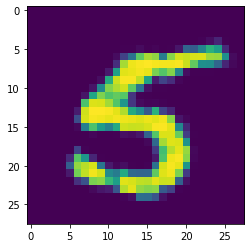

In [8]:
## Testing previously trained G
# visualize(sess, dcgan, FLAGS, 1, FLAGS.sample_dir)
z_sample = np.random.uniform(-1, 1, size=(num_samples, FLAGS.z_dim))

y = np.random.choice(FLAGS.y_dim, num_samples)
y_one_hot = np.zeros((num_samples, FLAGS.y_dim))
y_one_hot[np.arange(num_samples), y] = 1

samples = sess.run(dcgan.sampler, feed_dict={dcgan.z: z_sample, dcgan.y: y_one_hot})
plt.imshow(samples[0,:,:,0])

In [9]:
## steerability walk
## define the graph
z_placeholder = tf.placeholder(tf.float32, [None, FLAGS.z_dim], name='z_sample')
y_placeholder = tf.placeholder(tf.float32, [None, FLAGS.y_dim], name='y_sample')

## this will go to get_target and then to the loss
outputs_orig = dcgan.my_sampler(z_placeholder, y_placeholder)

img_size = 28
Nsliders = 1
target = tf.placeholder(tf.float32, shape=(None, img_size, img_size, Nsliders))
mask = tf.placeholder(tf.float32, shape=(None, img_size, img_size, Nsliders))
alpha = tf.placeholder(tf.float32, shape=None)
w = tf.Variable(np.random.uniform(-1, 1, [1, FLAGS.z_dim]), name='walk', dtype=np.float32)

z_new = z_placeholder+alpha*w
y_new = y_placeholder

## this is our transformed
transformed_output = dcgan.my_sampler(z_new, y_new)

loss = tf.losses.compute_weighted_loss(tf.square(transformed_output-target), weights=mask)
lr = 0.005
train_step = tf.train.AdamOptimizer(lr).minimize(loss, var_list=tf.trainable_variables(scope='walk'), 
                                                 name='AdamOpter')

## the graph already contains DCGAN and now we want to init the steerability part in it:
not_initialized_vars = initialize_uninitialized(sess)

['walk:0', 'beta1_power:0', 'beta2_power:0', 'walk/Adam:0', 'walk/Adam_1:0']


In [10]:
def get_target_np(outputs_zs, alpha, show_img=False, show_mask=False):
    target_fn = np.copy(outputs_zs)
    mask_fn = np.ones(outputs_zs.shape)
#     print('rotate with alphas:', alpha)
    mask_out = np.zeros(outputs_zs.shape)

    for i in range(outputs_zs.shape[0]):
        if alpha!=0:
            M = cv2.getRotationMatrix2D((img_size//2, img_size//2), alpha, 1)
            target_fn[i,:,:,:] = np.expand_dims(cv2.warpAffine(outputs_zs[i,:,:,:], M, (img_size, img_size)), axis=2)
            mask_fn[i,:,:,:] = np.expand_dims(cv2.warpAffine(mask_fn[i,:,:,:], M, (img_size, img_size)), axis=2)
            mask_out[i,:,:,:] = np.expand_dims(cv2.warpAffine(mask_fn[i,:,:,:], M, (img_size, img_size)), axis=2)
        else:
            mask_out[i,:,:,:] = mask_fn[i,:,:,:]

    mask_out[np.nonzero(mask_out)] = 1.
    assert(np.setdiff1d(mask_out, [0., 1.]).size == 0)

    if show_img:
        print('Target image:')
        imshow(imgrid(np.uint8(target_fn*255), cols=4))

    if show_mask:
        print('Target mask:')
        imshow(imgrid(np.uint8(mask_out*255), cols=4))

    return target_fn, mask_out


In [11]:
# ! mkdir -p shift_l2_git/images
# ! mkdir -p shift_l2_git/output
import os
output_dir = './out/argminW/rot2d_aug_l2_lr{}'.format(lr)
os.makedirs(os.path.join(output_dir, 'images'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'output'), exist_ok=True)
saver = tf.train.Saver(tf.trainable_variables(scope=None))

In [12]:
# This can be train.py

import logging
import sys
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(threadName)-12.12s] [%(levelname)-5.5s]  %(message)s",
    handlers=[
        logging.FileHandler("{0}/{1}.log".format(output_dir, 'train')),
        logging.StreamHandler(sys.stdout)
    ])
logger = logging.getLogger()

alpha_list = []
loss_vals = []

# train
train_sample_size = 20000
def train(saver):
    # init zs
    # we want couple of thousands per category, also compatible with batch_size
    num_samples = train_sample_size
    # sample inputs to feed to placeholders
    zs = np.random.uniform(-1, 1, size=(num_samples, FLAGS.z_dim))

    # all categories
    y = np.random.choice(FLAGS.y_dim, num_samples)
    ys = np.zeros((num_samples, FLAGS.y_dim))
    ys[np.arange(num_samples), y] = 1

    Loss_sum = 0;
    n_epoch = 1
    optim_iter = 0
    batch_size = FLAGS.batch_size
    loss_values = []
    Loss_sum_iter = 0  
    
    for epoch in range(n_epoch):
        for batch_start in range(0, num_samples, batch_size):
            start_time = time.time()
            
            alpha_val = np.random.randint(1, 21)  
            coin = np.random.uniform(0, 1)
            if coin <= 0.5:
                alpha_val = -alpha_val 

            s = slice(batch_start, min(num_samples, batch_start + batch_size))

            feed_dict_out = {z_placeholder: zs[s], y_placeholder: ys[s]}
            out_zs = sess.run(outputs_orig, feed_dict_out)
            
            target_fn, mask_out = get_target_np(out_zs, alpha_val)#, show_img=True, show_mask=True)

            feed_dict = {z_placeholder: zs[s], y_placeholder: ys[s], alpha: alpha_val, target: target_fn, mask: mask_out}
            curr_loss, _ = sess.run([loss, train_step], feed_dict=feed_dict)

            Loss_sum = Loss_sum + curr_loss
            Loss_sum_iter = Loss_sum_iter + curr_loss
            
            elapsed_time = time.time() - start_time

            logger.info('T, epc, bst, lss, a: {}, {}, {}, {}, {}'.format(elapsed_time, epoch, batch_start, curr_loss, alpha_val))

            alpha_list.append(alpha_val)

            if (optim_iter % 2500 == 0) and (optim_iter > 0):
                saver.save(sess, '{}/{}/model_{}.ckpt'.format(output_dir, 'output', optim_iter*batch_size), write_meta_graph=False, write_state=False)
            
            if (optim_iter % 100 == 0) and (optim_iter > 0):
                loss_vals.append(Loss_sum_iter/(100*batch_size))
                Loss_sum_iter = 0
                print('Loss:', loss_vals)

            optim_iter = optim_iter+1
            
    if optim_iter > 0:
        print('average loss with this metric: ', Loss_sum/(optim_iter*batch_size))
    saver.save(sess, '{}/{}/model_{}.ckpt'.format(output_dir, 'output', optim_iter*batch_size), write_meta_graph=False, write_state=False)

In [13]:
train(dcgan.saver)

2019-09-22 17:25:43,154 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.22890400886535645, 0, 0, 0.14081144332885742, 3
2019-09-22 17:25:43,163 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008331537246704102, 0, 10, 0.1974593847990036, -14
2019-09-22 17:25:43,174 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009624004364013672, 0, 20, 0.15432734787464142, 8
2019-09-22 17:25:43,185 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009870529174804688, 0, 30, 0.16111987829208374, -16
2019-09-22 17:25:43,197 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010487556457519531, 0, 40, 0.1524275243282318, -11
2019-09-22 17:25:43,207 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009575605392456055, 0, 50, 0.14323897659778595, -5
2019-09-22 17:25:43,218 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009169340133666992, 0, 60, 0.13034804165363312, -5
2019-09-22 17:25:43,229 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010053873062133789, 0, 70, 0.1141185611486435, 3
2019-09-22 17:25:43,240 [Main

2019-09-22 17:25:43,908 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010594844818115234, 0, 670, 0.14302381873130798, 14
2019-09-22 17:25:43,920 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010704994201660156, 0, 680, 0.15295657515525818, 20
2019-09-22 17:25:43,932 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010288238525390625, 0, 690, 0.11530616134405136, -15
2019-09-22 17:25:43,943 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010015487670898438, 0, 700, 0.14480742812156677, 19
2019-09-22 17:25:43,954 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009267807006835938, 0, 710, 0.12682144343852997, -7
2019-09-22 17:25:43,964 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009010076522827148, 0, 720, 0.1317993551492691, -9
2019-09-22 17:25:43,974 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009439706802368164, 0, 730, 0.14556628465652466, -18
2019-09-22 17:25:43,985 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009733438491821289, 0, 740, 0.1377054899930954, 14
2019-09-22 17:25

2019-09-22 17:25:44,630 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008280038833618164, 0, 1340, 0.11273449659347534, 9
2019-09-22 17:25:44,639 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007773637771606445, 0, 1350, 0.0878610834479332, -18
2019-09-22 17:25:44,648 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008144140243530273, 0, 1360, 0.0536859855055809, 1
2019-09-22 17:25:44,658 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008256673812866211, 0, 1370, 0.1010516807436943, -14
2019-09-22 17:25:44,667 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008121967315673828, 0, 1380, 0.13334284722805023, 20
2019-09-22 17:25:44,677 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00862574577331543, 0, 1390, 0.1116860881447792, -19
2019-09-22 17:25:44,687 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008734464645385742, 0, 1400, 0.13157442212104797, 13
2019-09-22 17:25:44,697 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00871729850769043, 0, 1410, 0.10252620279788971, -6
2019-09-22 17

Loss: [0.013484087564051152, 0.010685297559946776]
2019-09-22 17:25:45,343 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010681390762329102, 0, 2010, 0.10663371533155441, 10
2019-09-22 17:25:45,354 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009965658187866211, 0, 2020, 0.10491454601287842, -11
2019-09-22 17:25:45,365 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009513616561889648, 0, 2030, 0.09429735690355301, 3
2019-09-22 17:25:45,376 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009519100189208984, 0, 2040, 0.08555766195058823, -5
2019-09-22 17:25:45,387 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009990930557250977, 0, 2050, 0.08644415438175201, 5
2019-09-22 17:25:45,397 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009473800659179688, 0, 2060, 0.10476096719503403, -15
2019-09-22 17:25:45,408 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009816646575927734, 0, 2070, 0.10216853022575378, 6
2019-09-22 17:25:45,422 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01244497299

2019-09-22 17:25:46,076 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009480714797973633, 0, 2670, 0.08844632655382156, -14
2019-09-22 17:25:46,086 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00923013687133789, 0, 2680, 0.12019743770360947, -15
2019-09-22 17:25:46,097 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009673595428466797, 0, 2690, 0.10368023067712784, -10
2019-09-22 17:25:46,108 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009825468063354492, 0, 2700, 0.04018077626824379, 1
2019-09-22 17:25:46,119 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00964808464050293, 0, 2710, 0.11610177904367447, -7
2019-09-22 17:25:46,135 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.014755010604858398, 0, 2720, 0.11398415267467499, -16
2019-09-22 17:25:46,147 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010634183883666992, 0, 2730, 0.11082302778959274, -17
2019-09-22 17:25:46,157 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009546995162963867, 0, 2740, 0.08145597577095032, 9
2019-09

2019-09-22 17:25:46,783 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009410858154296875, 0, 3330, 0.1013193130493164, 5
2019-09-22 17:25:46,794 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010101795196533203, 0, 3340, 0.08376984298229218, 3
2019-09-22 17:25:46,806 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009927511215209961, 0, 3350, 0.0878242626786232, -3
2019-09-22 17:25:46,817 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010320186614990234, 0, 3360, 0.120847687125206, -10
2019-09-22 17:25:46,828 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010025978088378906, 0, 3370, 0.12073583155870438, -16
2019-09-22 17:25:46,839 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009104490280151367, 0, 3380, 0.08885987102985382, -15
2019-09-22 17:25:46,849 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008934497833251953, 0, 3390, 0.10732564330101013, -13
2019-09-22 17:25:46,858 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008877754211425781, 0, 3400, 0.11135859042406082, 17
2019-09-22

2019-09-22 17:25:47,513 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009119510650634766, 0, 4000, 0.09905053675174713, 4
Loss: [0.013484087564051152, 0.010685297559946776, 0.010135400354862214, 0.010046595584601165]
2019-09-22 17:25:47,525 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01097869873046875, 0, 4010, 0.08679556101560593, 5
2019-09-22 17:25:47,536 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009627580642700195, 0, 4020, 0.11376424133777618, 13
2019-09-22 17:25:47,547 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009942293167114258, 0, 4030, 0.1111917644739151, 19
2019-09-22 17:25:47,558 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009795904159545898, 0, 4040, 0.10259579867124557, -8
2019-09-22 17:25:47,569 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009465217590332031, 0, 4050, 0.10887828469276428, -19
2019-09-22 17:25:47,579 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009373188018798828, 0, 4060, 0.12115645408630371, -6
2019-09-22 17:25:47,590 [MainThread  ] [

2019-09-22 17:25:48,224 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009119033813476562, 0, 4660, 0.11151230335235596, 19
2019-09-22 17:25:48,235 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009678840637207031, 0, 4670, 0.09683699160814285, 15
2019-09-22 17:25:48,246 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009145021438598633, 0, 4680, 0.032108183950185776, 1
2019-09-22 17:25:48,256 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00957179069519043, 0, 4690, 0.10146432369947433, 17
2019-09-22 17:25:48,266 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008920907974243164, 0, 4700, 0.0920235738158226, -16
2019-09-22 17:25:48,277 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009067535400390625, 0, 4710, 0.07433114945888519, 2
2019-09-22 17:25:48,287 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009404182434082031, 0, 4720, 0.11515393108129501, 8
2019-09-22 17:25:48,298 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009717226028442383, 0, 4730, 0.08776820451021194, 6
2019-09-22 1

2019-09-22 17:25:48,921 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009559154510498047, 0, 5320, 0.09848654270172119, 13
2019-09-22 17:25:48,934 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.011715412139892578, 0, 5330, 0.07263191789388657, 2
2019-09-22 17:25:48,944 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009356021881103516, 0, 5340, 0.10109841078519821, -12
2019-09-22 17:25:48,959 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.013576030731201172, 0, 5350, 0.09664300084114075, -7
2019-09-22 17:25:48,969 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009155035018920898, 0, 5360, 0.1057603508234024, -18
2019-09-22 17:25:48,978 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007434844970703125, 0, 5370, 0.048560962080955505, -1
2019-09-22 17:25:48,987 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00842142105102539, 0, 5380, 0.049543995410203934, -1
2019-09-22 17:25:48,997 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008738040924072266, 0, 5390, 0.08977647870779037, 10
2019-09

2019-09-22 17:25:49,658 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009783029556274414, 0, 5990, 0.10763575881719589, 16
2019-09-22 17:25:49,669 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009729385375976562, 0, 6000, 0.08866401016712189, -13
Loss: [0.013484087564051152, 0.010685297559946776, 0.010135400354862214, 0.010046595584601165, 0.009685703691095114, 0.009560937326401472]
2019-09-22 17:25:49,682 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.011143207550048828, 0, 6010, 0.10030540078878403, -13
2019-09-22 17:25:49,693 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009408712387084961, 0, 6020, 0.11442341655492783, -9
2019-09-22 17:25:49,704 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009342432022094727, 0, 6030, 0.12347560375928879, 14
2019-09-22 17:25:49,714 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009524345397949219, 0, 6040, 0.10808718949556351, -14
2019-09-22 17:25:49,725 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009159564971923828, 0, 6050, 0.108730815351

2019-09-22 17:25:50,397 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009404897689819336, 0, 6650, 0.10704487562179565, 16
2019-09-22 17:25:50,407 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008896589279174805, 0, 6660, 0.09234296530485153, -11
2019-09-22 17:25:50,418 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010129451751708984, 0, 6670, 0.10004409402608871, -11
2019-09-22 17:25:50,429 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009675741195678711, 0, 6680, 0.031295377761125565, 1
2019-09-22 17:25:50,441 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010191679000854492, 0, 6690, 0.09407737106084824, -11
2019-09-22 17:25:50,454 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010289669036865234, 0, 6700, 0.06403123587369919, -2
2019-09-22 17:25:50,465 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009625911712646484, 0, 6710, 0.029576022177934647, 1
2019-09-22 17:25:50,476 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00957942008972168, 0, 6720, 0.1009322851896286, 7
2019-09-

2019-09-22 17:25:51,135 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010295391082763672, 0, 7300, 0.10107852518558502, 18
2019-09-22 17:25:51,146 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0098419189453125, 0, 7310, 0.08416233211755753, 15
2019-09-22 17:25:51,157 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009537220001220703, 0, 7320, 0.09487401694059372, 17
2019-09-22 17:25:51,168 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009452342987060547, 0, 7330, 0.10742730647325516, 11
2019-09-22 17:25:51,179 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009426116943359375, 0, 7340, 0.1012318879365921, -10
2019-09-22 17:25:51,189 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00964665412902832, 0, 7350, 0.08702047914266586, 5
2019-09-22 17:25:51,200 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009388446807861328, 0, 7360, 0.10382802784442902, 14
2019-09-22 17:25:51,210 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009566783905029297, 0, 7370, 0.08294274657964706, -5
2019-09-22 1

2019-09-22 17:25:51,850 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009408712387084961, 0, 7970, 0.1018100157380104, 7
2019-09-22 17:25:51,861 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009539127349853516, 0, 7980, 0.1016114130616188, -12
2019-09-22 17:25:51,871 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009273052215576172, 0, 7990, 0.09850551187992096, 13
2019-09-22 17:25:51,882 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009495019912719727, 0, 8000, 0.0955440104007721, -11
Loss: [0.013484087564051152, 0.010685297559946776, 0.010135400354862214, 0.010046595584601165, 0.009685703691095114, 0.009560937326401472, 0.009109678899869323, 0.009669800765812397]
2019-09-22 17:25:51,893 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009779930114746094, 0, 8010, 0.10803680121898651, -4
2019-09-22 17:25:51,904 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009142875671386719, 0, 8020, 0.08890963345766068, -10
2019-09-22 17:25:51,915 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010

2019-09-22 17:25:52,558 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01044464111328125, 0, 8620, 0.11476489901542664, -10
2019-09-22 17:25:52,572 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01250004768371582, 0, 8630, 0.10354581475257874, -14
2019-09-22 17:25:52,583 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009831666946411133, 0, 8640, 0.07865745574235916, -13
2019-09-22 17:25:52,594 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009334087371826172, 0, 8650, 0.12052369862794876, 16
2019-09-22 17:25:52,605 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010320901870727539, 0, 8660, 0.0992555022239685, -10
2019-09-22 17:25:52,616 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010072946548461914, 0, 8670, 0.08048510551452637, 3
2019-09-22 17:25:52,630 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.012377738952636719, 0, 8680, 0.07644408196210861, 4
2019-09-22 17:25:52,641 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0096282958984375, 0, 8690, 0.0834181159734726, -10
2019-09-22 

2019-09-22 17:25:53,263 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00887608528137207, 0, 9270, 0.09723492711782455, -7
2019-09-22 17:25:53,274 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008941173553466797, 0, 9280, 0.035573817789554596, -1
2019-09-22 17:25:53,284 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009715795516967773, 0, 9290, 0.07354960590600967, -2
2019-09-22 17:25:53,296 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009965896606445312, 0, 9300, 0.11150295287370682, 9
2019-09-22 17:25:53,307 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010635852813720703, 0, 9310, 0.10839430242776871, -15
2019-09-22 17:25:53,320 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.011865377426147461, 0, 9320, 0.08953320235013962, 5
2019-09-22 17:25:53,332 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010600805282592773, 0, 9330, 0.10352135449647903, 8
2019-09-22 17:25:53,343 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009783267974853516, 0, 9340, 0.10848528891801834, -9
2019-09-22

2019-09-22 17:25:53,988 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009671449661254883, 0, 9940, 0.11489228159189224, 13
2019-09-22 17:25:53,998 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009400129318237305, 0, 9950, 0.1002776250243187, 12
2019-09-22 17:25:54,009 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009558439254760742, 0, 9960, 0.04635082930326462, -1
2019-09-22 17:25:54,019 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009517908096313477, 0, 9970, 0.12319880723953247, -15
2019-09-22 17:25:54,029 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00904226303100586, 0, 9980, 0.09565902501344681, -13
2019-09-22 17:25:54,040 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00941157341003418, 0, 9990, 0.10024534910917282, -15
2019-09-22 17:25:54,051 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009615421295166016, 0, 10000, 0.08582817018032074, 9
Loss: [0.013484087564051152, 0.010685297559946776, 0.010135400354862214, 0.010046595584601165, 0.009685703691095114, 0.0095609373264

2019-09-22 17:25:54,701 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009573936462402344, 0, 10580, 0.1377047896385193, -18
2019-09-22 17:25:54,712 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010147333145141602, 0, 10590, 0.08981931954622269, -3
2019-09-22 17:25:54,723 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00953221321105957, 0, 10600, 0.10055989772081375, 13
2019-09-22 17:25:54,734 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009593486785888672, 0, 10610, 0.0938543975353241, 9
2019-09-22 17:25:54,744 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00949406623840332, 0, 10620, 0.08956752717494965, 11
2019-09-22 17:25:54,755 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009282350540161133, 0, 10630, 0.08918363600969315, 12
2019-09-22 17:25:54,766 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010114431381225586, 0, 10640, 0.09620856493711472, 10
2019-09-22 17:25:54,778 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010641336441040039, 0, 10650, 0.1046658605337143, 16
2019-

2019-09-22 17:25:55,414 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009410858154296875, 0, 11220, 0.12282650172710419, -10
2019-09-22 17:25:55,425 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010113716125488281, 0, 11230, 0.1002839133143425, 7
2019-09-22 17:25:55,436 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009654045104980469, 0, 11240, 0.11768146604299545, 10
2019-09-22 17:25:55,447 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009603500366210938, 0, 11250, 0.09933070838451385, -19
2019-09-22 17:25:55,457 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009660005569458008, 0, 11260, 0.0903627946972847, -13
2019-09-22 17:25:55,468 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009815692901611328, 0, 11270, 0.09766926616430283, -5
2019-09-22 17:25:55,483 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.013486385345458984, 0, 11280, 0.10775493085384369, -12
2019-09-22 17:25:55,494 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009711027145385742, 0, 11290, 0.0776142030954361, 6
2

2019-09-22 17:25:56,129 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009221315383911133, 0, 11880, 0.1150326132774353, 16
2019-09-22 17:25:56,139 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009148120880126953, 0, 11890, 0.07888367772102356, -6
2019-09-22 17:25:56,150 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009447574615478516, 0, 11900, 0.0947350561618805, -11
2019-09-22 17:25:56,161 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009947776794433594, 0, 11910, 0.11319500207901001, 15
2019-09-22 17:25:56,172 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009379863739013672, 0, 11920, 0.09049878269433975, 13
2019-09-22 17:25:56,183 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009755134582519531, 0, 11930, 0.08522048592567444, -7
2019-09-22 17:25:56,194 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009869575500488281, 0, 11940, 0.07708103209733963, -5
2019-09-22 17:25:56,204 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009489774703979492, 0, 11950, 0.0864861011505127, 4
201

2019-09-22 17:25:56,840 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009828329086303711, 0, 12520, 0.06572159379720688, -5
2019-09-22 17:25:56,852 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010397672653198242, 0, 12530, 0.10756063461303711, -8
2019-09-22 17:25:56,863 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010026693344116211, 0, 12540, 0.08796057105064392, 14
2019-09-22 17:25:56,874 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009676456451416016, 0, 12550, 0.11920924484729767, -14
2019-09-22 17:25:56,885 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010063886642456055, 0, 12560, 0.09248051047325134, -10
2019-09-22 17:25:56,897 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010296821594238281, 0, 12570, 0.10178543627262115, 8
2019-09-22 17:25:56,908 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010322093963623047, 0, 12580, 0.10622063279151917, 19
2019-09-22 17:25:56,924 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.014620542526245117, 0, 12590, 0.10298654437065125, 12

2019-09-22 17:25:57,609 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010025262832641602, 0, 13160, 0.09754324704408646, -12
2019-09-22 17:25:57,619 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009594202041625977, 0, 13170, 0.10486531257629395, 16
2019-09-22 17:25:57,630 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009759902954101562, 0, 13180, 0.081930972635746, 4
2019-09-22 17:25:57,641 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009900093078613281, 0, 13190, 0.09356504678726196, -7
2019-09-22 17:25:57,653 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010262489318847656, 0, 13200, 0.10221375524997711, -4
2019-09-22 17:25:57,664 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010294914245605469, 0, 13210, 0.11587640643119812, -9
2019-09-22 17:25:57,675 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00986623764038086, 0, 13220, 0.06186503916978836, 3
2019-09-22 17:25:57,687 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010113954544067383, 0, 13230, 0.09694498777389526, -12
201

2019-09-22 17:25:58,357 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009551048278808594, 0, 13820, 0.05193464457988739, 2
2019-09-22 17:25:58,366 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008373022079467773, 0, 13830, 0.08952176570892334, -4
2019-09-22 17:25:58,378 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010378599166870117, 0, 13840, 0.020070375874638557, 1
2019-09-22 17:25:58,390 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.011222124099731445, 0, 13850, 0.11632110178470612, -20
2019-09-22 17:25:58,402 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010651350021362305, 0, 13860, 0.09566239267587662, -12
2019-09-22 17:25:58,414 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0107421875, 0, 13870, 0.06791677325963974, 4
2019-09-22 17:25:58,426 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010689258575439453, 0, 13880, 0.0966198593378067, 9
2019-09-22 17:25:58,438 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010533809661865234, 0, 13890, 0.09836448729038239, 19
2019-09-22

2019-09-22 17:25:59,063 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009063243865966797, 0, 14460, 0.10383342951536179, -17
2019-09-22 17:25:59,077 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.012272357940673828, 0, 14470, 0.04836398363113403, -2
2019-09-22 17:25:59,089 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010592222213745117, 0, 14480, 0.11647402495145798, -14
2019-09-22 17:25:59,099 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009577512741088867, 0, 14490, 0.08402347564697266, -15
2019-09-22 17:25:59,110 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009452104568481445, 0, 14500, 0.08472474664449692, 12
2019-09-22 17:25:59,121 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009471893310546875, 0, 14510, 0.12340372055768967, -7
2019-09-22 17:25:59,131 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009445905685424805, 0, 14520, 0.05519634857773781, 3
2019-09-22 17:25:59,142 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00974583625793457, 0, 14530, 0.08359333127737045, 6


2019-09-22 17:25:59,770 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009545326232910156, 0, 15100, 0.10618338733911514, -9
2019-09-22 17:25:59,780 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009401082992553711, 0, 15110, 0.07242101430892944, -3
2019-09-22 17:25:59,793 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.012080907821655273, 0, 15120, 0.0773661732673645, 5
2019-09-22 17:25:59,804 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009291887283325195, 0, 15130, 0.056892279535532, -2
2019-09-22 17:25:59,815 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009727954864501953, 0, 15140, 0.08049140870571136, 5
2019-09-22 17:25:59,826 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009915828704833984, 0, 15150, 0.07141393423080444, -4
2019-09-22 17:25:59,837 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009941339492797852, 0, 15160, 0.09854408353567123, 7
2019-09-22 17:25:59,848 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010102033615112305, 0, 15170, 0.13236229121685028, -20
2019-

2019-09-22 17:26:00,541 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00956583023071289, 0, 15760, 0.0716472938656807, 15
2019-09-22 17:26:00,552 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009630918502807617, 0, 15770, 0.10541782528162003, -8
2019-09-22 17:26:00,563 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009438037872314453, 0, 15780, 0.08675955981016159, -12
2019-09-22 17:26:00,574 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01007699966430664, 0, 15790, 0.1016281396150589, -9
2019-09-22 17:26:00,585 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010011911392211914, 0, 15800, 0.10497217625379562, -7
2019-09-22 17:26:00,596 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009705781936645508, 0, 15810, 0.10673196613788605, -20
2019-09-22 17:26:00,608 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010687589645385742, 0, 15820, 0.08514798432588577, -16
2019-09-22 17:26:00,620 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010879039764404297, 0, 15830, 0.07132291048765182, -4
2

2019-09-22 17:26:01,239 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009545326232910156, 0, 16390, 0.0507812425494194, 4
2019-09-22 17:26:01,250 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009326934814453125, 0, 16400, 0.09818867594003677, 13
2019-09-22 17:26:01,260 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009254217147827148, 0, 16410, 0.09905809164047241, -8
2019-09-22 17:26:01,270 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009170770645141602, 0, 16420, 0.08097674697637558, -16
2019-09-22 17:26:01,280 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009153127670288086, 0, 16430, 0.0897156298160553, -11
2019-09-22 17:26:01,291 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00936436653137207, 0, 16440, 0.1046486496925354, 16
2019-09-22 17:26:01,301 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00930476188659668, 0, 16450, 0.10627453774213791, 17
2019-09-22 17:26:01,312 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009232759475708008, 0, 16460, 0.08757009357213974, -9
2019

2019-09-22 17:26:01,943 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009741067886352539, 0, 17020, 0.07392581552267075, 7
2019-09-22 17:26:01,954 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009822368621826172, 0, 17030, 0.10482184588909149, -19
2019-09-22 17:26:01,966 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010285615921020508, 0, 17040, 0.07255089282989502, 10
2019-09-22 17:26:01,976 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009716272354125977, 0, 17050, 0.06683817505836487, 4
2019-09-22 17:26:01,987 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009389400482177734, 0, 17060, 0.08619917929172516, -11
2019-09-22 17:26:01,997 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008945465087890625, 0, 17070, 0.10909590870141983, -13
2019-09-22 17:26:02,007 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009179353713989258, 0, 17080, 0.10572639852762222, -13
2019-09-22 17:26:02,018 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00990748405456543, 0, 17090, 0.09920646995306015, 15

2019-09-22 17:26:02,676 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010267019271850586, 0, 17680, 0.06726724654436111, -5
2019-09-22 17:26:02,687 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010081291198730469, 0, 17690, 0.07205677777528763, 8
2019-09-22 17:26:02,698 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009651899337768555, 0, 17700, 0.10063647478818893, -19
2019-09-22 17:26:02,709 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009990453720092773, 0, 17710, 0.008550591766834259, -1
2019-09-22 17:26:02,720 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009910106658935547, 0, 17720, 0.1019103080034256, -13
2019-09-22 17:26:02,731 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010051250457763672, 0, 17730, 0.09961681067943573, -13
2019-09-22 17:26:02,741 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009402275085449219, 0, 17740, 0.030465776100754738, -2
2019-09-22 17:26:02,751 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00915217399597168, 0, 17750, 0.10351566225290298, -

2019-09-22 17:26:03,355 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009497404098510742, 0, 18310, 0.09348393976688385, 13
2019-09-22 17:26:03,366 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009127378463745117, 0, 18320, 0.06986638903617859, -6
2019-09-22 17:26:03,376 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00931239128112793, 0, 18330, 0.10012773424386978, 8
2019-09-22 17:26:03,387 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009784936904907227, 0, 18340, 0.11620037257671356, 18
2019-09-22 17:26:03,398 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010150909423828125, 0, 18350, 0.020314881578087807, 3
2019-09-22 17:26:03,409 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009829521179199219, 0, 18360, 0.07551601529121399, -6
2019-09-22 17:26:03,420 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009459972381591797, 0, 18370, 0.09997954964637756, -13
2019-09-22 17:26:03,430 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009464025497436523, 0, 18380, 0.08413075655698776, -10


2019-09-22 17:26:04,072 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009403467178344727, 0, 18970, 0.002784296404570341, 1
2019-09-22 17:26:04,082 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009305238723754883, 0, 18980, 0.03141503036022186, 6
2019-09-22 17:26:04,093 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009619951248168945, 0, 18990, 0.08552457392215729, 19
2019-09-22 17:26:04,104 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009314298629760742, 0, 19000, 0.029133610427379608, -4
Loss: [0.013484087564051152, 0.010685297559946776, 0.010135400354862214, 0.010046595584601165, 0.009685703691095114, 0.009560937326401472, 0.009109678899869323, 0.009669800765812397, 0.00923748678714037, 0.009347263323143125, 0.009566251957789063, 0.00936815406382084, 0.009173236798495054, 0.008413094775751234, 0.008915745053440333, 0.00875534562021494, 0.008310062796808779, 0.008518684636801482, 0.007053357859142124]
2019-09-22 17:26:04,115 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0096065

2019-09-22 17:26:04,769 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009377479553222656, 0, 19600, 0.013422587886452675, 6
2019-09-22 17:26:04,781 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010474443435668945, 0, 19610, 0.06536886841058731, 18
2019-09-22 17:26:04,793 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.011010169982910156, 0, 19620, 0.005710895638912916, 3
2019-09-22 17:26:04,803 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009359598159790039, 0, 19630, 0.0429813377559185, 16
2019-09-22 17:26:04,814 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009310483932495117, 0, 19640, 0.036296822130680084, 10
2019-09-22 17:26:04,824 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009353399276733398, 0, 19650, 0.02397405542433262, -7
2019-09-22 17:26:04,834 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00914144515991211, 0, 19660, 0.010931513272225857, 4
2019-09-22 17:26:04,849 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.013488292694091797, 0, 19670, 0.026814699172973633, 7
2

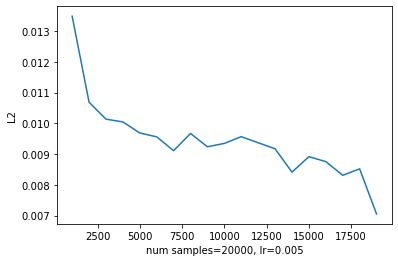

[0.013484087564051152, 0.010685297559946776, 0.010135400354862214, 0.010046595584601165, 0.009685703691095114, 0.009560937326401472, 0.009109678899869323, 0.009669800765812397, 0.00923748678714037, 0.009347263323143125, 0.009566251957789063, 0.00936815406382084, 0.009173236798495054, 0.008413094775751234, 0.008915745053440333, 0.00875534562021494, 0.008310062796808779, 0.008518684636801482, 0.007053357859142124]


In [14]:
import matplotlib.pyplot as plt
loss_vals_x = np.arange(FLAGS.batch_size*100, train_sample_size, FLAGS.batch_size*100)
plt.plot(loss_vals_x, loss_vals)
plt.xlabel('num samples={}, lr={}'.format(train_sample_size, lr))
plt.ylabel('L2')
plt.show()
print(loss_vals)

In [15]:
# test: show imgs 
# Need work:
# saver.restore(sess, "./out/argminW/zoom_NoAug_l2_lr0.005/output/model_20000.ckpt")

[-30. -24. -18. -12.  -6.   0.   6.  12.  18.  24.  30.]


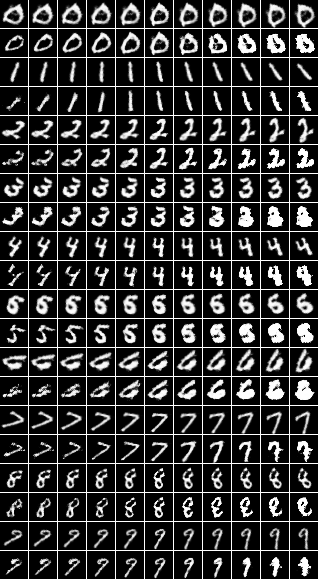

In [16]:
num_samples = 10

# a = np.linspace(-180,180, 11)
a = np.linspace(-30,30,11)
zs = np.random.uniform(-1, 1, size=(num_samples, FLAGS.z_dim))
y = np.arange(0,FLAGS.y_dim,1)
ys = np.zeros((num_samples, FLAGS.y_dim))
ys[np.arange(num_samples), y] = 1

im_targets = []
im_transformed = []
for i in range(a.shape[0]):
    feed_dict_out = {z_placeholder: zs, y_placeholder: ys}
    out_zs = sess.run(outputs_orig, feed_dict_out)
    target_fn, mask_out = get_target_np(out_zs, a[i])#, show_img=True, show_mask=True)
    im_targets.append(target_fn)
    ## get transformed:
    feed_dict = {z_placeholder: zs, y_placeholder: ys, alpha: a[i], target: target_fn, mask: mask_out}
    samples = sess.run(transformed_output, feed_dict=feed_dict)
    im_transformed.append(samples)
#     imshow(imgrid(np.uint8(samples*255), cols=1))

ims = []
for j in range(FLAGS.y_dim):
    ims.append(np.stack([x[j, :, :, :] for x in im_targets], axis=0))
    ims.append(np.stack([x[j, :, :, :] for x in im_transformed], axis=0))

print(a)
imshow(imgrid(np.uint8(np.concatenate(ims)*255), cols=a.shape[0]))

In [17]:
loss_l2_sample = tf.reduce_sum(tf.multiply(tf.square(transformed_output-target), mask), axis=(1,2,3)) \
        / tf.reduce_sum(mask, axis=(1,2,3))

loss_l2_trained = loss

In [18]:
import logging
import sys
# import argparse
# from utils import *
# import graphs
# import constants
import time
import pdb
import os
# import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 14})
rc('text', usetex=True)

num_samples = 10000
vocab_size = FLAGS.y_dim
batch_size = FLAGS.batch_size

z_sample = np.random.uniform(-1, 1, size=(num_samples, FLAGS.z_dim))
y = np.arange(0,FLAGS.y_dim,1)
y_one_hot = np.zeros((len(y), FLAGS.y_dim))
y_one_hot[np.arange(len(y)), y] = 1
y_one_hot = np.tile(y_one_hot,[num_samples,1])

zs = z_sample
ys = y_one_hot
alphas = a 
alphas_no_log = a

# get alphas list
# if type(g) == graphs.ZoomTransform:
#     alp = np.linspace(1, opt.max_alpha, opt.num_alphas//2 + 1)
#     b = 1/alp
#     alphas = np.concatenate((np.delete(b[::-1], -1), alp), axis=0)
#     alphas = alphas[::-1]
# else:
#     alphas = np.linspace(-opt.max_alpha, opt.max_alpha, opt.num_alphas)
ylabel = 'L2 Distance'
dist_tensor = loss_l2_sample
dist_trained_tensor = loss_l2_trained

# dist_info = compute_transform_similarity(...)
# plot_similarity(dist_info...)

# # if opt.distance == 'l2':
# #     ylabel = 'L2 Distance'
# #     dist_tensor = g.loss_l2_sample
# # elif opt.distance == 'lpips':
# #     ylabel = 'Perceptual Distance'
# #     dist_tensor = g.loss_lpips_sample
# dist_info = compute_transform_similarity(ys, zs, alphas, dist_tensor)
# plot_similarity(alphas, dist_info, ylabel, output_dir, 'category_all')
# # if opt.category:
# #     for c in opt.category:
# #         ys = [c] * num_samples
# #         ys = one_hot_if_needed(ys, vocab_size)
# #         dist_info = compute_transform_similarity(g, ys, zs, alphas,
# #                                                  dist_tensor)
# #         plot_similarity(alphas, dist_info, ylabel,
# #                         output_dir, 'category_{}'.format(c))
# # else:
# #     categories = np.random.randint(0, vocab_size, size=num_samples)
# #     ys = one_hot_if_needed(categories, vocab_size)
# #     dist_info = compute_transform_similarity(g, ys, zs, alphas,
# #                                              dist_tensor)
# #     plot_similarity(alphas, dist_info, ylabel, output_dir,
# #                     'category_all')

In [19]:
def scale_test_alpha_for_graph(alpha, zs_batch):
#     alpha = np.log(alpha) # only for zoom
    batch_size = zs_batch.shape[0]
    slider = alpha * np.ones((batch_size, Nsliders))
    return slider

In [20]:
alphas = alphas_no_log
dist_info = np.empty((num_samples, len(alphas) - 1))
dist_trained_info = np.empty((num_samples, len(alphas)))

for batch_start in range(0, num_samples, batch_size):
    s = slice(batch_start, min(num_samples, batch_start + batch_size))
    ys_batch = ys[s]
    zs_batch = zs[s]
    im_buffer = None # save the first set of images, for consecutive diff
    for i, a in enumerate(alphas):
        slider = scale_test_alpha_for_graph(a, zs_batch)
        input_test = {y_placeholder: ys_batch,
                      z_placeholder: zs_batch,
                      alpha: slider}
        im_transform = sess.run(transformed_output, feed_dict=input_test)
#         imshow(imgrid(np.uint8(im_transform*255), cols=1))
        if im_buffer is not None:
            feed_dict = {
                mask: np.ones_like(im_transform),
                transformed_output: im_transform,
                target: im_buffer
            }
            # compute consecutive lpips diffs
            dist_info[s, i-1] = sess.run(dist_tensor, feed_dict=feed_dict)
#             print('consecutive diffs:', sess.run(dist_tensor, feed_dict=feed_dict))
        im_buffer = im_transform
    
        ## now compute the loss of train:
        ## already have im_transform, so get target and mask from G(a=0,z)
        out_zs = sess.run(outputs_orig, input_test)
        target_out, mask_out = get_target_np(out_zs, a)
#         imshow(imgrid(np.uint8(im_transform*255), cols=1))
#         imshow(imgrid(np.uint8(target_out*255), cols=1))
#         imshow(imgrid(np.uint8(mask_out*255), cols=1))
        feed_dict = {
            mask: mask_out,
            transformed_output: im_transform,
            target: target_out
        }
        dist_trained_info[s, i] = sess.run(dist_trained_tensor, feed_dict=feed_dict)

alpha: -27.00, dist 0.01 +/- 0.01
alpha: -21.00, dist 0.01 +/- 0.01
alpha: -15.00, dist 0.02 +/- 0.01
alpha: -9.00, dist 0.02 +/- 0.01
alpha: -3.00, dist 0.02 +/- 0.01
alpha: 3.00, dist 0.02 +/- 0.01
alpha: 9.00, dist 0.02 +/- 0.01
alpha: 15.00, dist 0.02 +/- 0.01
alpha: 21.00, dist 0.02 +/- 0.01
alpha: 27.00, dist 0.01 +/- 0.01
2019-09-22 17:28:12,672 [MainThread  ] [INFO ]  No LaTeX-compatible font found for the serif font family in rcParams. Using default.
2019-09-22 17:28:12,674 [MainThread  ] [INFO ]  No LaTeX-compatible font found for the serif font family in rcParams. Using default.


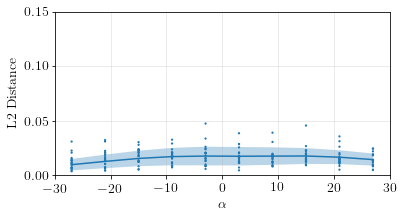

In [21]:
## plots and saves the computed similarity matrix
output_dir = './out/plots/plots_rot2d'
savefile_transform_effect = file_name+'_transform_effect_plots'

alphas = alphas_no_log

xlabel = r'$\alpha$'
if np.min(alphas) > 0:
    alphas = np.log(alphas)
    xlabel = r'$\log(\alpha)$'
    
f, ax = plt.subplots(figsize=(6, 3))
xaxis = np.mean([alphas[:-1], alphas[1:]], axis=0)
mu = np.mean(dist_info, axis=0)
sd = np.std(dist_info, axis=0)
p = ax.plot(xaxis, mu)
ax.fill_between(xaxis, mu-sd, mu+sd, alpha=0.3)
xscatter = np.tile(xaxis, (20, 1))
yscatter = dist_info[:20] # take the first 20 samples
ax.scatter(xscatter, yscatter, marker='.',
           edgecolors='none', s=20, color=p[0].get_color())
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)

# ax.set_ylim([0, 0.8])
ax.set_ylim([0, 0.15])
ax.grid(alpha=0.3)
# ax.set_xlim([np.min(alphas), np.max(alphas)])
ax.set_xlim([np.min(alphas), np.max(alphas)])

for (x, m, s) in zip(xaxis, mu, sd):
    print("alpha: {:.2f}, dist {:.2f} +/- {:.2f}".format(x, m, s))

f.savefig(os.path.join(output_dir, savefile_transform_effect + '.png'),
          bbox_inches="tight", pad_inches=0)
f.savefig(os.path.join(output_dir, savefile_transform_effect + '.pdf'),
          bbox_inches="tight", pad_inches=0)

In [22]:
dist_trained_joint = np.load(os.path.join(output_dir, 'rot2d_aug_argminGW_alphamax20_lr0.0002_loss_trained_plots.npy'))
dist_trained_NoAug_argminGW = np.load(os.path.join(output_dir, 'rot2d_NoAug_argminGW_alpahmax20_lr0.0002_loss_trained_plots.npy'))
dist_trained_NoAug_argminW = np.load(os.path.join(output_dir, 'rot2d_NoAug_argminW_alphamax20_lr0.0002_loss_trained_plots.npy'))
                                     

alpha: -30.00, dist 0.07 +/- 0.01
alpha: -24.00, dist 0.06 +/- 0.01
alpha: -18.00, dist 0.04 +/- 0.01
alpha: -12.00, dist 0.03 +/- 0.00
alpha: -6.00, dist 0.01 +/- 0.00
alpha: 0.00, dist 0.00 +/- 0.00
alpha: 6.00, dist 0.01 +/- 0.00
alpha: 12.00, dist 0.04 +/- 0.00
alpha: 18.00, dist 0.07 +/- 0.01
alpha: 24.00, dist 0.10 +/- 0.01
alpha: 30.00, dist 0.12 +/- 0.01


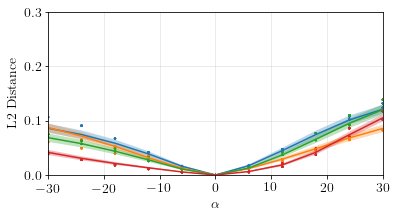

In [23]:
## plots and saves the computed similarity matrix
output_dir = './out/plots/plots_rot2d'
savefile_loss = file_name+'_loss_trained_plots'

alphas = alphas_no_log

xlabel = r'$\alpha$'
if np.min(alphas) > 0:
    alphas = np.log(alphas)
    xlabel = r'$\log(\alpha)$'
    
f, ax = plt.subplots(figsize=(6, 3))
# xaxis = np.mean([alphas[:-1], alphas[1:]], axis=0)
xaxis = np.mean([alphas[:], alphas[:]], axis=0)
# mu = np.mean(dist_trained_info, axis=0)
# sd = np.std(dist_trained_info, axis=0)
# p = ax.plot(xaxis, mu)
# ax.fill_between(xaxis, mu-sd, mu+sd, alpha=0.3)
# xscatter = np.tile(xaxis, (20, 1))
# yscatter = dist_trained_info[:20] # take the first 20 samples
# ax.scatter(xscatter, yscatter, marker='.',
#            edgecolors='none', s=20, color=p[0].get_color())


### For noaug + walk
mu_j = np.mean(dist_trained_NoAug_argminW, axis=0)
sd_j = np.std(dist_trained_NoAug_argminW, axis=0)
p_j = ax.plot(xaxis, mu_j)
ax.fill_between(xaxis, mu_j-sd_j, mu_j+sd_j, alpha=0.3)
xscatter_j = np.tile(xaxis, (20,1))
yscatter_j = dist_trained_NoAug_argminW[:20]
ax.scatter(xscatter_j, yscatter_j, marker='.', edgecolors='none', s=20, color=p_j[0].get_color())

### For noaug + joint
mu_j = np.mean(dist_trained_NoAug_argminGW, axis=0)
sd_j = np.std(dist_trained_NoAug_argminGW, axis=0)
p_j = ax.plot(xaxis, mu_j)
ax.fill_between(xaxis, mu_j-sd_j, mu_j+sd_j, alpha=0.3)
xscatter_j = np.tile(xaxis, (20,1))
yscatter_j = dist_trained_NoAug_argminGW[:20]
ax.scatter(xscatter_j, yscatter_j, marker='.', edgecolors='none', s=20, color=p_j[0].get_color())

### For shift aug+walk (this file)
mu = np.mean(dist_trained_info, axis=0)
sd = np.std(dist_trained_info, axis=0)
p = ax.plot(xaxis, mu)
ax.fill_between(xaxis, mu-sd, mu+sd, alpha=0.3)
xscatter = np.tile(xaxis, (20, 1))
yscatter = dist_trained_info[:20] # take the first 20 samples
ax.scatter(xscatter, yscatter, marker='.',
           edgecolors='none', s=20, color=p[0].get_color())
### For shift join
mu_j = np.mean(dist_trained_joint, axis=0)
sd_j = np.std(dist_trained_joint, axis=0)
p_j = ax.plot(xaxis, mu_j)
ax.fill_between(xaxis, mu_j-sd_j, mu_j+sd_j, alpha=0.3)
xscatter_j = np.tile(xaxis, (20,1))
yscatter_j = dist_trained_joint[:20]
ax.scatter(xscatter_j, yscatter_j, marker='.', edgecolors='none', s=20, color=p_j[0].get_color())

ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)

# ax.set_ylim([0, 0.8])
ax.set_ylim([0, 0.3])
ax.grid(alpha=0.3)
# ax.set_xlim([np.min(alphas), np.max(alphas)])
ax.set_xlim([np.min(alphas), np.max(alphas)])

for (x, m, s) in zip(xaxis, mu, sd):
    print("alpha: {:.2f}, dist {:.2f} +/- {:.2f}".format(x, m, s))

f.savefig(os.path.join(output_dir, savefile_loss + '.png'),
          bbox_inches="tight", pad_inches=0)
f.savefig(os.path.join(output_dir, savefile_loss + '.pdf'),
          bbox_inches="tight", pad_inches=0)

In [24]:
np.save(os.path.join(output_dir, savefile_transform_effect+'.npy'), dist_info)
np.save(os.path.join(output_dir, savefile_loss+'.npy'), dist_trained_info)